In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision

from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import optim
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import save_image
from BVAA import VAE

In [52]:
batch_size = 64

mnist_dataset = datasets.MNIST('../../data', 
                   train=True, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

mnist_dataset_test = datasets.MNIST('../../data', train=False, download=True, transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(mnist_dataset_test, batch_size=1, shuffle=True)


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [51]:
test_batch_size = 1
batch_size = 64
epochs = 2
lr = 0.1
gamma = 0.7
seed = 1
no_cuda = False
log_interval = 1000
save_model = True
use_cuda = True
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [5]:
model = VAE([1, 32, 32], 12)
model_siamese = VAE([1, 32, 32], 12)

In [6]:
model.load_state_dict(torch.load('./model/betaVAE.pt'))
model_siamese.load_state_dict(torch.load('./model/Siamese/G/G-200.pt'))

<All keys matched successfully>

In [7]:
from BVAA import Net
model_classification = Net().to(device)
optimizer = optim.Adadelta(model_classification.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [8]:
from BVAA import train, test
for epoch in range(1, epochs + 1):
    train(model_classification, device, train_loader, optimizer, epoch)
    test(model_classification, model.to(device), device, test_loader)
    test(model_classification, model_siamese.to(device), device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323310

Test set: Average loss: 0.1857, Accuracy: 9487/10000 (95%)


Test set: Average loss: 1.3399, Accuracy: 7399/10000 (74%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.361222

Test set: Average loss: 0.1807, Accuracy: 9514/10000 (95%)


Test set: Average loss: 1.4513, Accuracy: 7392/10000 (74%)



In [9]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [10]:
(example_targets == 4).nonzero().data

tensor([[11],
        [22],
        [29],
        [31],
        [33]])

In [ ]:
t = []

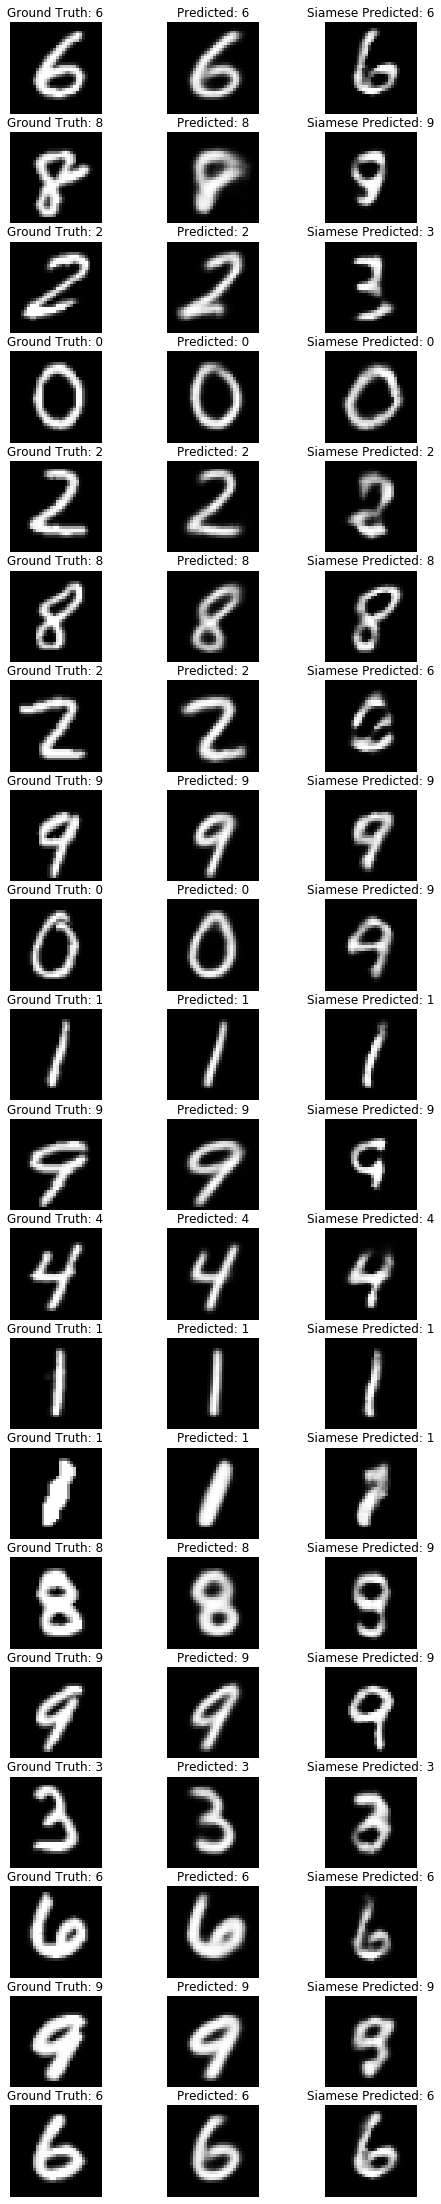

In [33]:
plt.figure(figsize=(8,40))
for i in range(20):
#     print(i)
    recon_img,_,_ = model(torch.FloatTensor(example_data[i]).unsqueeze(0).to(device))
    recon_img_siamese,_,_ = model_siamese(torch.FloatTensor(example_data[i]).unsqueeze(0).to(device))
    plt.subplot(20,3, 3*i+1)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.axis('off')
    plt.subplot(20,3,3*i+2)
    plt.imshow(recon_img[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title("Predicted: {}".format(torch.argmax(model_classification(recon_img)).item()))
    plt.axis('off')
    plt.subplot(20,3,3*i+3)
    plt.imshow(recon_img_siamese[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title("Siamese Predicted: {}".format(torch.argmax(model_classification(recon_img_siamese)).item()))
    plt.axis('off')

In [34]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [70]:
def test( model, vae_model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        
        # Send the data and label to the device
        data_hat,_,_ = vae_model(torch.FloatTensor(data).to(device))
        target = target.to(device)
        
        # Set requires_grad attribute of tensor. Important for Attack
#         data = data.to(device)
#         data.requires_grad = True
#         print(data.grad)

        # Forward pass the data through the model
        data_hat = data_hat.detach()
        data_hat.requires_grad = True
#         print(data_hat.requires_grad)
        output = model(data_hat)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data_hat.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_hat, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [71]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model_classification, model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9510 / 10000 = 0.951
Epsilon: 0.05	Test Accuracy = 8421 / 10000 = 0.8421
Epsilon: 0.1	Test Accuracy = 5686 / 10000 = 0.5686
Epsilon: 0.15	Test Accuracy = 2120 / 10000 = 0.212
Epsilon: 0.2	Test Accuracy = 511 / 10000 = 0.0511
Epsilon: 0.25	Test Accuracy = 152 / 10000 = 0.0152
Epsilon: 0.3	Test Accuracy = 33 / 10000 = 0.0033


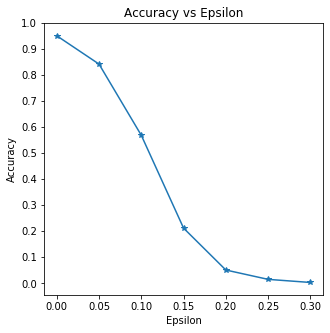

In [72]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

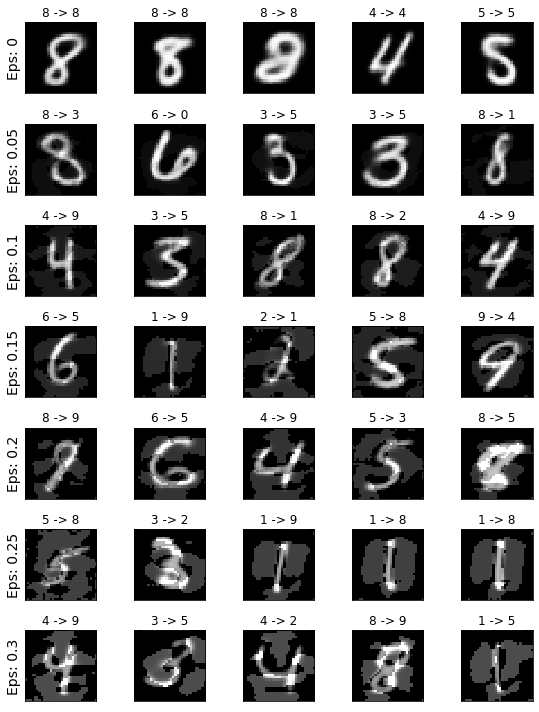

In [73]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

In [75]:
accuracies_s = []
examples_s = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model_classification, model_siamese, device, test_loader, eps)
    accuracies_s.append(acc)
    examples_s.append(ex)

Epsilon: 0	Test Accuracy = 7392 / 10000 = 0.7392
Epsilon: 0.05	Test Accuracy = 5855 / 10000 = 0.5855
Epsilon: 0.1	Test Accuracy = 4095 / 10000 = 0.4095
Epsilon: 0.15	Test Accuracy = 1873 / 10000 = 0.1873
Epsilon: 0.2	Test Accuracy = 711 / 10000 = 0.0711
Epsilon: 0.25	Test Accuracy = 325 / 10000 = 0.0325
Epsilon: 0.3	Test Accuracy = 57 / 10000 = 0.0057


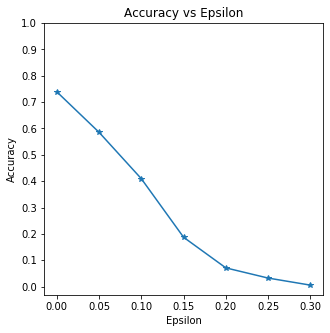

In [76]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_s, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

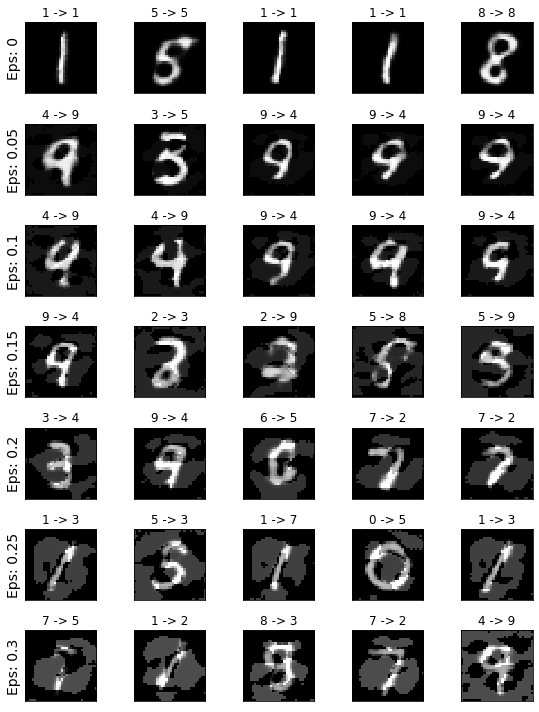

In [77]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples_s[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_s[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples_s[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()